<a href="https://colab.research.google.com/github/Mohammed-Faazil-16/movie_recommendation_system/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome! Please sign in or sign up to use the Movie Recommendation System.
Type 'sign in' to log in or 'sign up' to register: SIGN IN
Enter your username: FAAZIL
Enter your password: MARTHAKIMAAKA
Invalid credentials! Please try again.
Enter your username: marthakimaaka
Enter your password: Faazil
Invalid credentials! Please try again.
Enter your username: faazil
Enter your password: marthakimaaka
Login successful!
Enter your favourite movie name: superman
HERE ARE MOVIES YOU WOULD ALSO LIKE!!!


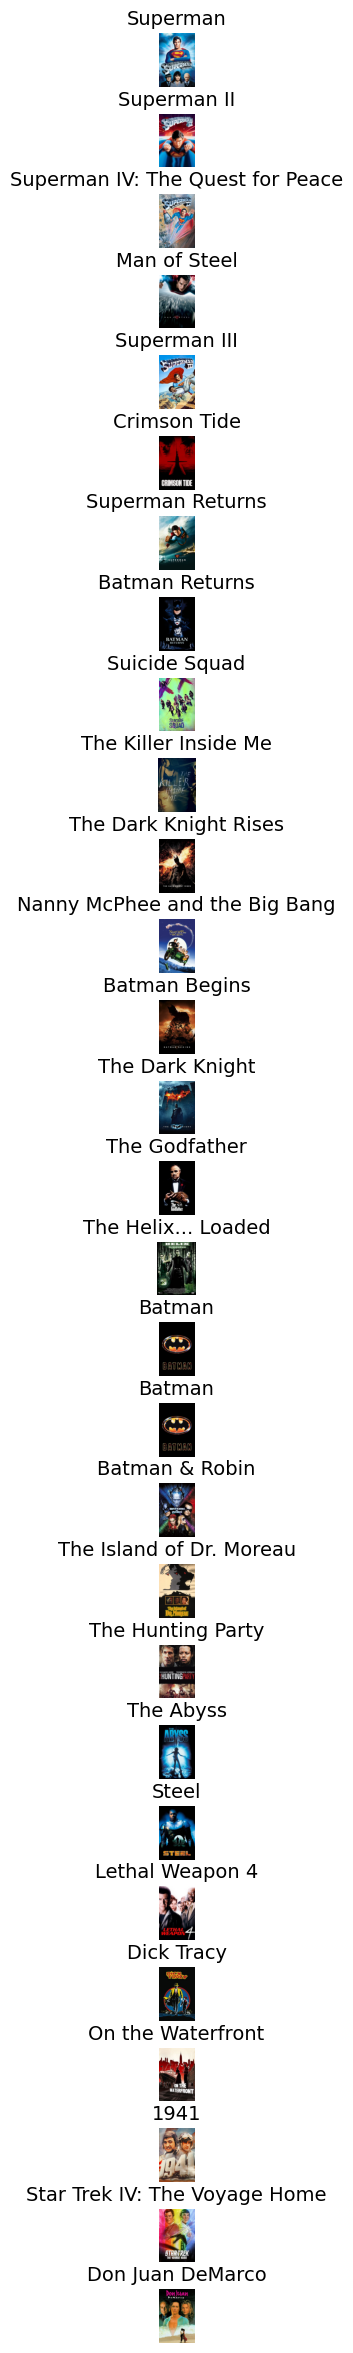

In [5]:
import numpy as np
import pandas as pd
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import sqlite3
import hashlib

# Database setup
conn = sqlite3.connect('users.db')
c = conn.cursor()

# Create table if it doesn't exist
c.execute('''CREATE TABLE IF NOT EXISTS users
             (username TEXT PRIMARY KEY, password TEXT)''')
conn.commit()

# Hashing function for passwords
def hash_password(password):
    return hashlib.sha256(password.encode()).hexdigest()

# Sign-up function
def sign_up():
    username = input("Enter a username: ")
    c.execute("SELECT * FROM users WHERE username = ?", (username,))
    if c.fetchone():
        print("Username already exists! Please try again.")
        return sign_up()

    password = input("Enter a password: ")
    hashed_password = hash_password(password)
    c.execute("INSERT INTO users (username, password) VALUES (?, ?)", (username, hashed_password))
    conn.commit()
    print("User registered successfully!")

# Sign-in function
def sign_in():
    username = input("Enter your username: ")
    password = input("Enter your password: ")
    hashed_password = hash_password(password)
    c.execute("SELECT * FROM users WHERE username = ? AND password = ?", (username, hashed_password))
    if c.fetchone():
        print("Login successful!")
        return True
    else:
        print("Invalid credentials! Please try again.")
        return sign_in()

# Ask the user to sign in or sign up
print("Welcome! Please sign in or sign up to use the Movie Recommendation System.")
while True:
    action = input("Type 'sign in' to log in or 'sign up' to register: ").lower()
    if action == 'sign in':
        if sign_in():
            break
    elif action == 'sign up':
        sign_up()
    else:
        print("Invalid option, please type 'sign in' or 'sign up'.")

# Data Collection and Pre-Processing

# loading the data from the csv file to a pandas dataframe
movies_data = pd.read_csv('movies.csv')

# selecting the relevant features for recommendation
selected_features = ['genres','keywords','tagline','cast','director']


# replacing the null values with null string
for feature in selected_features:
    movies_data[feature] = movies_data[feature].fillna('')

# combining all the 5 selected features
combined_features = movies_data['genres']+' '+movies_data['keywords']+' '+movies_data['tagline']+' '+movies_data['cast']+' '+movies_data['director']


# converting the text data to feature vectors
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)


# Cosine Similarity

# getting the similarity scores using cosine similarity
similarity = cosine_similarity(feature_vectors)


# Getting the movie name from the user
movie_name = input('Enter your favourite movie name: ')

# creating a list with all the movie names given in the dataset
list_of_all_titles = movies_data['title'].tolist()

# finding the close match for the movie name given by the user
find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)


close_match = find_close_match[0]


# finding the index of the movie with title
index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]


# getting a list of similar movies
similarity_score = list(enumerate(similarity[index_of_the_movie]))


# sorting the movies based on their similarity score
sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)


# print the name of similar movies based on the index
movie_list = []
i = 1

for movie in sorted_similar_movies:
    index = movie[0]
    title_from_index = movies_data[movies_data.index == index]['title'].values[0]
    if i < 30:
        movie_list.append(title_from_index)
        i += 1

# Movie Poster Display

API_KEY = '31b1e60b9e5ec9908ece9580a1aea0ab'
BASE_URL = 'https://api.themoviedb.org/3'

def get_movie_poster(movie_name):
    search_url = f"{BASE_URL}/search/movie"
    params = {'api_key': API_KEY, 'query': movie_name}
    response = requests.get(search_url, params=params)
    data = response.json()

    if data['results']:
        movie = data['results'][0]
        poster_path = movie.get('poster_path')
        if poster_path:
            poster_url = f"https://image.tmdb.org/t/p/w300{poster_path}"
            return poster_url
    return None

def display_movie_logos(movie_list):
    plt.figure(figsize=(20, 30))

    for index, movie_name in enumerate(movie_list):
        poster_url = get_movie_poster(movie_name)

        if poster_url:
            response = requests.get(poster_url)
            img_data = response.content
            img = Image.open(BytesIO(img_data))

            plt.subplot(len(movie_list), 1, index + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(movie_name, fontsize=14)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

print("HERE ARE MOVIES YOU WOULD ALSO LIKE!!!")
display_movie_logos(movie_list)

# Close the database connection
conn.close()
